# 第四次作业：Actor-Critic 和 PPO 算法

**本次作业一共包括两个部分：ActorCritic算法和PPO算法。我们分别需要分别实现两个算法，并在离散和连续动作环境（CartPole和Pendulum）下测试算法效果。**

**同学们需要完成三个代码实现（通过注释方式标出），并调节参数画出实验效果图。**

# 第一部分：ActorCritic算法
## 简介
之前我们介绍的Q-learning和DQN及改进算法都是基于值函数（value-based）的方法，其中Q-learning是处理有限状态的算法，而DQN可以用来解决连续状态的问题。在强化学习中，除了基于值函数的方法，还有一支非常经典的方法，那就是基于策略（policy-based）的方法。对比两者，基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略，此时并不存在一个显式的策略。而基于策略的方法则是直接显式的学习一个目标策略。策略梯度是基于策略的方法的基础，我们将从策略梯度算法说起。
## 策略梯度
基于策略的方法首先需要参数化策略，我们假设目标策略$\pi_\theta$是一个随机性策略，并且处处可微，其中$\theta$是对应的参数。我们的目标是要寻找一个最优策略，来最大化这个策略在环境中的期望回报。我们将策略学习的目标函数定义为
$$
J(\theta)= V^{\pi_\theta}(s_0)
$$
其中$s_0$表示初始状态。现在有了目标函数，我们将目标函数对策略$\theta$求导，得到导数后，我们就可以用梯度上升方法来最大化这个目标函数从而得到最优策略。

我们之前在MDP章节中学习过在策略$\pi$下的状态访问分布，我们在此用$d^{\pi}$表示。然后我们对目标函数求梯度，可以得到如下式子，更详细的推导将在扩展阅读中给出。

$$
\begin{aligned}
\nabla_{\theta}J(\theta)
&\propto \sum_{s \in S}d^{\pi}(s)\sum_{a \in A}Q^{\pi}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)\\
&=\sum_{s \in S}d^{\pi}(s)\sum_{a \in A}\pi_{\theta}(a|s)Q^{\pi}(s,a)\frac{\nabla_{\theta}\pi_{\theta}(a|s)}{\pi_{\theta}(a|s)}\\
&= \mathbb{E}_{\pi}[Q^{\pi}(s,a)\nabla_{\theta}\ln \pi_{\theta}(a|s)]
\end{aligned}
$$
于是，我们就可以用这个梯度来更新策略。需要注意的是，因为上式期望的下标是$\pi$，所以策略梯度算法为在线学习算法，即必须使用策略$\pi_\theta$采样得到的数据来计算梯度。更一般地，我们可以把梯度写成下面这个形式：
$$
g = \mathbb{E}[\sum^{\infty}_{t=0}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})]
$$
其中$\psi_{t}$可以有很多种形式：
$$
\begin{aligned}
&1.\psi_{t}=\sum_{t=0}^{\infty}\gamma^t r_{t} : 轨迹的总回报  &&4.Q^{\pi}(s_{t},a_{t}) : 动作价值函数\\
&2.\psi_{t}=\sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'} : 动作 a_{t}之后的回报 &&5.A^{\pi}(s_{t},a_{t}): 优势函数\\
&3.\psi_{t}=\sum_{t'=t}^{\infty}r_{t'}-b(s_{t}) : 基准线版本的改进 \quad\quad \quad\quad &&6.r_{t} + V^{\pi}(s_{t+1}) - V^{\pi}(s_t) : 时序差分残差
\end{aligned}
$$
至此，我们已经了解了策略梯度的目标与形式，那么我们今天要讲的ActorCritic算法的流程是怎样的呢？
## ActorCritic 算法
最基本的PolicyGradient算法就是上文中的1式$\psi_{t}=\sum_{t=0}^{\infty}\gamma^t r_{t}$，而ActorCritic就是通过value function来估计return值，即在上文中$\psi=Q^{\pi}(s_{t},a_{t})$式。

两个常见的改进：baseline和advantage分别对应3和5式。结合两个改进，得到我们今天需要实现的AdvantageActorCritic算法，即式6: 
$$\psi_{t}=r_{t} + V^{\pi}(s_{t+1}) - V^{\pi}(s_t)$$

具体流程如下：
$$
\begin{aligned}
&1.初始化策略参数\theta \\
&2.用当前策略\pi_\theta采样轨迹\{s_{1},a_{1},r_{1},s_{2},a_{2},r_{2} ... s_{t},a_{t},r_{t}\}\\
&3.计算当前轨迹的回报\sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'}作为\psi_{t}\\
&4.对\theta进行更新 \theta = \theta + \alpha \psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})\\
&5.重复2-4步
\end{aligned}
$$

好了！这就是REINFORCE算法的全部啦，让我们来用代码实现它看看效果如何吧！



## 代码实践
我们在Cartpole环境中进行REINFORCE算法的实验。首先我们导入包

In [1]:
#!pip install gym
import gym

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import Categorical, Normal
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import random

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
eps = np.finfo(np.float32).eps.item()

In [3]:
def smooth_curve(y, smooth):
    r = smooth
    length = int(np.prod(y.shape))
    for i in range(length):
        if i > 0:
            if (not np.isinf(y[i - 1])) and (not np.isnan(y[i - 1])):
                y[i] = y[i - 1] * r + y[i] * (1 - r)
    return y

def moving_average(y, x=None, total_steps=100, smooth=0.9, move_max=False):
    if isinstance(y, list):
        y = np.array(y)
    length = int(np.prod(y.shape))
    if x is None:
        x = list(range(1, length+1))
    if isinstance(x, list):
        x = np.array(x)
    if length > total_steps:
        block_size = length//total_steps
        select_list = list(range(0, length, block_size))
        select_list = select_list[:-1]
        y = y[:len(select_list) * block_size].reshape(-1, block_size)
        if move_max:
            y = np.max(y, -1)
        else:
            y = np.mean(y, -1)
        x = x[select_list]
    y = smooth_curve(y, smooth)
    return y, x
def plotReward(infos):
    x, y = infos["episodes"],infos["rewards"]
    y, x = moving_average(y, x)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(x, y)
    plt.show()

定义基本网络单元Net

In [4]:
class Net(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size, layer_num=2):
        super(Net, self).__init__()
        # Use torch.nn.ModuleList or torch.nn.Sequential For multiple layers
        layers = []
        last_size = input_size
        for i in range(layer_num-1):
            layers.append(torch.nn.Linear(last_size, hidden_size))
            layers.append(torch.nn.ReLU())
            last_size = hidden_size
        layers.append(torch.nn.Linear(last_size, output_size))
        self._net = torch.nn.Sequential(*layers)

    def forward(self, inputs):
        return self._net(inputs)

再定义RL算法的基类RLAlgo，我们已经在该类中实现离散和连续动作的分布计算等函数

In [5]:
def trans2tensor(batch):
    for k in batch:
        # print(batch[k])
        if isinstance(batch[k], torch.Tensor):
            batch[k] = batch[k].to(device=device)
        elif isinstance(batch[k][0], torch.Tensor):
            batch[k] = torch.cat(batch[k]).to(device=device)
        else:
            batch[k] = torch.tensor(batch[k], device=device, dtype=torch.float32)

    return batch
class RLAlgo:
    def __init__(self,discrete_action=True, tau=0.01):
        self.discrete_action = discrete_action
        self._tau = tau
    
    # update target network
    def soft_update(self, source, target, tau=None):
        if tau is None:
            tau = self._tau
        with torch.no_grad():
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
    # sample actions
    def action(self, state):
        with torch.no_grad():
            p_out = self.policy(state)
        log_prob, action = self.dist(p_out)
        return action, log_prob
    
    # calculate probability of action
    def dist(self, p_out, action=None):
        if self.discrete_action:
            # ========================================
            # 【代码实现 1】: 请根据以下要求完成代码
            #  1. 根据policy网络输出p_out，通过softmax计算动作的分布dist
            #  2. 若action为None，根据分布dist采样得到动作action；若action不为None，使用输入的action
            #  3. 根据具体动作action和分布dist获得每个动作的概率log_prob
            # ========================================
            # ========================================
            # 【代码实现 1】
            # ========================================
            action_prob = F.softmax(p_out, dim=1)
            dist = Categorical(action_prob)
            if action is None:
                action = dist.sample()
            log_prob = dist.log_prob(action.T)
        else:
            # only for pendulum env
            mean, var = torch.chunk(p_out, 2, dim=-1)
            mean = 2 * torch.tanh(mean)
            var = torch.nn.functional.softplus(var)
            m = Normal(mean, var)
            if action is None:
                action = m.sample()
            log_prob = m.log_prob(action)
        
        return log_prob.reshape(-1, 1), action.reshape(-1, 1)
    
    # compute advantage
    def compute_adv(self, batch, gamma):
        s = batch["state"]
        a = batch["action"]
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        done = batch["done"].reshape(-1, 1)
        old_log_prob = batch["log_prob"].reshape(-1, 1)
        with torch.no_grad():
            adv = r + gamma * (1-done) * self.value(s1) - self.value(s)

        return adv

接下来，请实现ActorCritic算法。

在更新Agent的过程中，我们按照算法，将损失函数写为$L=(r_{t} + V^{\pi}(s_{t+1}) - V^{\pi}(s_t)) \log\pi_{\theta}(a_{t}|s_{t})$，对$\theta$求导就可以更新策略。

需要注意，分别计算value和policy网络的损失函数loss时，需要对无关变量进行detach，以免梯度计算错误。

In [6]:
# ========================================
# 【代码实现 2】: 补全完成ActorCritic算法
#  DEBUG建议： 1. 检查是否对无关变量detach 2.检查两个tenor运算前是否对齐维度 3.检查公式是否写错
# ========================================
class AdvantageActorCritic(RLAlgo):
    def __init__(
        self, 
        hidden_size, state_space, action_space, 
        learning_rate, **kwargs
    ):
        super(AdvantageActorCritic, self).__init__( **kwargs)
        self.action_space = action_space

        input_size = state_space.shape[0]
        if self.discrete_action:
            output_size = action_space.n
        else:
            output_size = action_space.shape[0]*2
        
        self.policy = Net(hidden_size, input_size, output_size)
        self.value = Net(hidden_size, input_size, 1)
        self.target_value = Net(hidden_size, input_size, 1)
        
        self.policy_optim = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.value_optim = torch.optim.Adam(self.value.parameters(), lr=learning_rate)
    
    def update(self, batch, gamma):
        s = batch["state"]
        a = batch["action"].reshape(-1, 1)
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        done = batch["done"].reshape(-1, 1)
        adv = batch["adv"]
        
        q_target = (r + gamma * (1 - done) * self.target_value(s1)).detach()
        q_predict = self.value(s)
        log_prob, action = self.dist(self.policy(s), a)
        self.value_optim.zero_grad()
        self.policy_optim.zero_grad()
        
        value_loss = nn.MSELoss()(q_target, q_predict)
        policy_loss = torch.mean(log_prob * adv)
        value_loss.backward()
        policy_loss.backward()
        self.value_optim.step()
        self.policy_optim.step()
        self.soft_update(self.value, self.target_value, self._tau)

定义好策略，我们就可以开始实验了，看看在Cartpole环境上表现如何吧！

In [7]:
env_name = "CartPole-v0"
env = gym.make(env_name)

In [8]:
max_timesteps = 1000
gamma = 0.99

env_name = "CartPole-v0"
env = gym.make(env_name)


def train(agent, num_episode=1000, mini_epoch=5, discrete_action=True, print_every=100):
    rewards_log = []
    episodes_log = []
    for i_episode in range(num_episode):
        states = []
        acts = []
        rewards = []
        next_states = []
        log_probs = []
        dones = []
        
        state = env.reset()
        env.seed(1)
        random.seed(1)
        
        state = torch.tensor([state], device=device, dtype=torch.float32)
        
        for time_step in range(max_timesteps):
            action, log_prob = agent.action(state)
            action = action.cpu()
            if discrete_action:
                next_state, reward, done, _ = env.step(action.numpy().reshape(-1)[0])
            else:
                
                next_state, reward, done, _ = env.step(action.numpy().reshape(-1))
                
            # collect samples
            states.append(state)
            acts.append(action)
            log_probs.append(log_prob.detach())
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            # log_probs.append(log_prob)
            
            state = torch.tensor([next_state], device=device, dtype=torch.float32)
            if done:
                break
        rewards_log.append(np.sum(rewards))
        episodes_log.append(i_episode)
        batch = trans2tensor({"state": states, "action":acts, 
                          "log_prob": log_probs,
                          "next_state": next_states, "done":dones, 
                          "reward": rewards, })
        r = batch["reward"] 
        batch["reward"] = (r - r.mean()) / (r.std() + 1e-8)
        batch["adv"] = agent.compute_adv(batch, gamma)
        for i in range(mini_epoch):
            agent.update(batch, gamma)
        if (i_episode + 1) % print_every == 0 or i_episode + 1 == num_episode:
            print("Episode: {}, Reward: {}".format(i_episode+1, np.mean(rewards_log[-10:])))
    # env.close()
    infos = {
        "rewards": rewards_log,
        "episodes": episodes_log
    }
    return infos

在CartPole-v0环境中，满分就是200分，让我们来看看每个Episode得分如何吧！

In [9]:
# 请自行调节参数
learning_rate = 1e-3
hidden_size = 256
agent = AdvantageActorCritic(
        hidden_size, 
        env.observation_space, 
        env.action_space, 
        learning_rate,
    )
ac_cartpole_infos = train(agent, 2000, 10)

Episode: 100, Reward: 77.7
Episode: 200, Reward: 52.6
Episode: 300, Reward: 138.9
Episode: 400, Reward: 154.6
Episode: 500, Reward: 141.6
Episode: 600, Reward: 188.5
Episode: 700, Reward: 199.8
Episode: 800, Reward: 200.0
Episode: 900, Reward: 143.8
Episode: 1000, Reward: 174.4
Episode: 1100, Reward: 177.2
Episode: 1200, Reward: 200.0
Episode: 1300, Reward: 166.8
Episode: 1400, Reward: 200.0
Episode: 1500, Reward: 108.3
Episode: 1600, Reward: 200.0
Episode: 1700, Reward: 192.7
Episode: 1800, Reward: 200.0
Episode: 1900, Reward: 180.1
Episode: 2000, Reward: 200.0


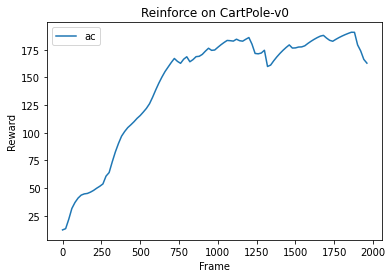

In [10]:
plt.title('Reinforce on {}'.format(env_name))  
plt.ylabel("Reward")
plt.xlabel("Frame")
infos = [ac_cartpole_infos,]
labels = ["ac", ]
for info in infos:
    x, y = info["episodes"],info["rewards"]
    y, x = moving_average(y, x)
    plt.plot(x, y)
plt.legend(labels)
plt.show()

## 拓展阅读：策略梯度证明
我们要证明$\nabla_{\theta}J(\theta) \propto \sum_{s \in S}d^{\pi}(s)\sum_{a \in A}Q^{\pi}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)$
                        
先从状态价值函数的推导开始：
$$
\begin{aligned}
\nabla_{\theta}V^{\pi}(s) &=\nabla_{\theta}(\sum_{a \in A} \pi_{\theta}(a|s)Q^{\pi}(s,a)) \\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi}(s,a) + \pi_{\theta}(a|s)\nabla_{\theta}Q^{\pi}(s,a))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi}(s,a) + \pi_{\theta}(a|s)\nabla_{\theta}\sum_{s',r}P(s',r|s,a)(r+V^{\pi}(s'))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi}(s,a) + \pi_{\theta}(a|s)\sum_{s',r}P(s',r|s,a)\nabla_{\theta}V^{\pi}(s'))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi}(s,a) + \pi_{\theta}(a|s)\sum_{s'}P(s'|s,a)\nabla_{\theta}V^{\pi}(s'))\\
\end{aligned}
$$
为了简化表示，我们让$\phi(s)=\sum_{a \in A}\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi}(s,a)$, 定义$\rho^{\pi}(s\rightarrow x, k)$为策略$\pi$从状态s出发k步后到达状态x的概率，我们继续推导:
$$
\begin{aligned}
\nabla_{\theta}V^{\pi}(s) &= \phi(s) + \sum_{a}\pi_{\theta}(a|s)\sum_{s'}P(s'|s,a)\nabla_{\theta}V^{\pi}(s')\\
&= \phi(s) + \sum_{a}\sum_{s'}\pi_{\theta}(a|s)P(s'|s,a)\nabla_{\theta}V^{\pi}(s')\\
&= \phi(s) + \sum_{s'}\rho^{\pi}(s \rightarrow s',1)\nabla_{\theta}V^{\pi}(s')\\
&= \phi(s) + \sum_{s'}\rho^{\pi}(s \rightarrow s',1)[\phi(s') + \sum_{s''}\rho^{\pi}(s' \rightarrow s'',1)\nabla_{\theta}V^{\pi}(s'')]\\
&= \phi(s) + \sum_{s'}\rho^{\pi}(s \rightarrow s',1)\phi(s') + \sum_{s''}\rho^{\pi}(s \rightarrow s'',2)\nabla_{\theta}V^{\pi}(s'')\\
&= \phi(s) + \sum_{s'}\rho^{\pi}(s \rightarrow s',1)\phi(s') +\sum_{s''}\rho^{\pi}(s' \rightarrow s'',2)\phi(s'') + \sum_{s'''}\rho^{\pi}(s \rightarrow s''',3)\nabla_{\theta}V^{\pi}(s''')\\
&= ......\\
&= \sum_{x \in S}\sum^{\infty}_{k=0}\rho^{\pi}(s \rightarrow x, k)\phi(x)
\end{aligned}
$$
OK! 我们定义$\eta(s)= \sum^{\infty}_{k=0}\rho^{\pi}(s_{0} \rightarrow s, k)$至此我们看回我们的目标函数：
$$
\begin{aligned}
\nabla_{\theta}J(\theta) &= \nabla_{\theta}V^{\pi}(s_{0})\\
&= \sum_{s}\sum^{\infty}_{k=0}\rho^{\pi}(s_{0} \rightarrow s, k)\phi(s)\\
&= \sum_{s}\eta(s)\phi(s)\\
&= (\sum_{s}\eta(s))\sum_{s}\frac{\eta(s)}{\sum_{s}\eta(s)}\phi(s)\\
&\propto \sum_{s}\frac{\eta(s)}{\sum_{s}\eta(s)}\phi(s)\\
&= \sum_{s}d^{\pi}(s)\sum_{a}Q^{\pi}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)
\end{aligned}
$$
证明完毕！

# 第二部分：PPO算法

之前介绍的TRPO在很多场景上都很成功，但是我们也发现了它的计算过程非常的复杂，每步更新的运算量非常大。于是，在2017年TRPO的改进版PPO算法被提出，它基于TRPO的思想，但是实现算法更加简单，避免了复杂的求KL散度的Hessian矩阵。并且大量的实验结果表明，PPO能够比TRPO学习的更快，这使得PPO一下子成为了非常流行的强化学习算法。如果我们想要尝试在一个新的环境用强化学习，那么PPO就属于那种可以首先尝试的算法。

## PPO算法

我们回忆一下TRPO的优化目标：
$$
 \mathbb{E}_{s\sim d^{\pi_{\theta_k}}}\mathbb E_{a\sim \pi_{\theta_k}(\cdot|s)}\left[ \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s,a)\right]\quad\text{s.t.}\quad D_{KL}^{d^{\pi_{\theta_k}}}(\pi_{\theta_k},\pi_\theta)\le\delta
$$

TRPO的做法是用KKT条件、近似、共轭梯度等方法直接对它求解的。PPO的优化目标同样是它，但PPO用了一些相对简单的方法来求解，其效果不差于TRPO。具体来说，PPO有两种形式，一是PPO-Penalty，二是PPO-Clip。

### PPO-Penalty

PPO-Penalty直接将KL散度的限制放进了目标函数中，这就变成了一个无约束的优化问题，然后在迭代的过程中不断更新KL散度前的系数。即
$$
\theta=\mathop{\arg\max}_\theta \mathbb{E}_{s\sim d^{\pi_{\theta_k}}}\mathbb E_{a\sim \pi_{\theta_k}(\cdot|s)}\left[ \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s,a)-\beta D_{KL}[\pi_{\theta_k}(\cdot|s),\pi_\theta(\cdot|s)]\right]
$$

令 $d=D_{KL}^{d^{\pi_{\theta_k}}}(\pi_{\theta_k},\pi_\theta)$，$\beta$ 的更新规则如下：
1. 如果$d<d_{target}/1.5$，那么$\beta\leftarrow \beta/2$
1. 如果$d>d_{target}\times1.5$，那么$\beta\leftarrow \beta\times 2$

### PPO-Clip

PPO-Clip更加直接，其直接在目标函数里进行限制，以保证新的参数和旧的参数的差距不会太大，即

$$
\theta=\mathop{\arg\max}_\theta \mathbb{E}_{s\sim d^{\pi_{\theta_k}}}\mathbb E_{a\sim \pi_{\theta_k}(\cdot|s)}\left[\min \left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s,a),\text{clip}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)},1-\epsilon,1+\epsilon\right)A^{\pi_{\theta_k}}(s,a)\right)\right]
$$

其中 $\text{clip}(x,l,r):=\max(\min(x,r),l)$ ，即把 $x$ 限制在 $[l,r]$ 内。上式中$\epsilon$是一个超参数，表示clip的范围。如果$A(s,a)>0$，说明这个动作的Q值高于平均，最大化这个式子会增大$\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$，但不会让其超过$1+\epsilon$。反之，如果$A(s,a)<0$，最大化这个式子会减小$\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$，但不会让其超过$1-\epsilon$。


## PPO代码实践

和TRPO一样，我们仍然在两个环境CartPle和Pendulum上测试PPO算法。实验表明，PPO-Clip总是比PPO-Penalty表现得更好。因此下面我们只出PPO-Clip的代码。
### 环境1: CartPole
我们先在离散动作环境CartPole上测试算法效果，下面实现具体的PPO算法。注意：只需在ActorCritic算法基础上修改loss计算的update函数即可。

In [11]:
# ========================================
# 【代码实现 3】: 补全完成PPO算法（具体实现与ActorCritic类似）
# ========================================
class PPO(RLAlgo):

    def __init__(
        self, 
        hidden_size, state_space, action_space, learning_rate,
        clip_range=0.2,
        **kwargs,
    ):
        super(PPO, self).__init__( **kwargs)
        self._clip_range = clip_range
        self.action_space = action_space

        input_size = state_space.shape[0]
        if self.discrete_action:
            output_size = action_space.n
        else:
            output_size = action_space.shape[0]*2
        
        self.policy = Net(hidden_size, input_size, output_size)
        self.value = Net(hidden_size, input_size, 1)
        self.target_value = Net(hidden_size, input_size, 1)
        
        self.policy_optim = torch.optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.value_optim = torch.optim.Adam(self.value.parameters(), lr=learning_rate)
    
    def update(self, batch, gamma):
        s = batch["state"]
        a = batch["action"]
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        adv = batch["adv"]
        done = batch["done"].reshape(-1, 1)
        old_log_prob = batch["log_prob"].reshape(-1, 1)
        
        q_target = (r + gamma * (1 - done) * self.target_value(s1)).detach()
        q_predict = self.value(s)
        log_prob, action = self.dist(self.policy(s), a)
        ratio = torch.exp(log_prob - old_log_prob)
        self.value_optim.zero_grad()
        self.policy_optim.zero_grad()
        
        value_loss = nn.MSELoss()(q_target, q_predict)
        loss1 = ratio * adv
        loss2 = torch.clamp(ratio, 1-self._clip_range, 1+self._clip_range) * adv
        policy_loss = torch.mean(- torch.min(loss1, loss2))
        
        value_loss.backward()
        policy_loss.backward()
        self.value_optim.step()
        self.policy_optim.step()
        
        self.soft_update(self.value, self.target_value, self._tau)

接下来，开始训练PPO算法

In [12]:
# 请自行调节参数
learning_rate = 1e-3
hidden_size= 256
agent = PPO(
        hidden_size=hidden_size, 
        state_space=env.observation_space, 
        action_space=env.action_space, 
        learning_rate=learning_rate,
    )
ppo_cartpole_infos = train(agent, 2000, 10)

Episode: 100, Reward: 193.2
Episode: 200, Reward: 109.4
Episode: 300, Reward: 105.6
Episode: 400, Reward: 174.9
Episode: 500, Reward: 132.2
Episode: 600, Reward: 116.8
Episode: 700, Reward: 131.4
Episode: 800, Reward: 176.3
Episode: 900, Reward: 200.0
Episode: 1000, Reward: 153.2
Episode: 1100, Reward: 200.0
Episode: 1200, Reward: 170.9
Episode: 1300, Reward: 178.3
Episode: 1400, Reward: 200.0
Episode: 1500, Reward: 200.0
Episode: 1600, Reward: 200.0
Episode: 1700, Reward: 200.0
Episode: 1800, Reward: 200.0
Episode: 1900, Reward: 200.0
Episode: 2000, Reward: 200.0


**请分别测试ActorCritic和PPO算法在该环境下的效果。**

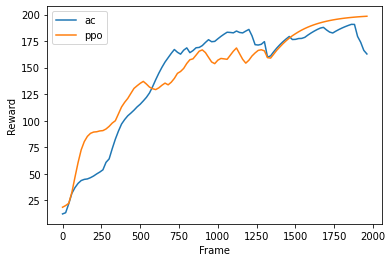

In [13]:
plt.ylabel("Reward")
plt.xlabel("Frame")
infos = [ac_cartpole_infos, ppo_cartpole_infos]
labels = ["ac", "ppo"]
for info in infos:
    x, y = info["episodes"],info["rewards"]
    y, x = moving_average(y, x)
    plt.plot(x, y)
plt.legend(labels)
plt.show()

### 环境2：Pendulum

接下来，我们比较两个算法在连续环境下的效果。对于不同环境，我们只需修改policy输出的分布即可，相关代码在RLAlgo的dist函数。

In [14]:
env_name = "Pendulum-v1"
env = gym.make(env_name)

seed = 0
env.seed(seed)
np.random.seed(seed)
# torch.manual_seed(seed)


**请分别测试ActorCritic和PPO算法在该环境下的效果。**

（由于ActorCritic在此环境下效果较差，不需要过度调参。只需保证PPO算法最后结果在$-500$以上即可。）

In [15]:
# 请自行调节参数
hidden_size = 256
learning_rate = 1e-3
agent = AdvantageActorCritic(
        hidden_size, 
        env.observation_space, 
        env.action_space, 
        learning_rate, 
        discrete_action=False
    )

ac_pendulum_infos = train(agent, 1500, 1, discrete_action=False)

Episode: 100, Reward: -1493.528455508166
Episode: 200, Reward: -1381.875762102326
Episode: 300, Reward: -1255.2275917683833
Episode: 400, Reward: -1434.3601899476112
Episode: 500, Reward: -1495.5610064329107
Episode: 600, Reward: -1403.9144880150236
Episode: 700, Reward: -1522.8494864512627
Episode: 800, Reward: -1508.850697448401
Episode: 900, Reward: -1522.1293450549163
Episode: 1000, Reward: -1520.5595253083338
Episode: 1100, Reward: -1502.8290378233642
Episode: 1200, Reward: -1538.318156193265
Episode: 1300, Reward: -1349.8087338253686
Episode: 1400, Reward: -1574.889714786453
Episode: 1500, Reward: -1520.8305275727325


In [16]:
# 请自行调节参数
hidden_size = 256
learning_rate = 1e-3
agent = PPO(
        hidden_size=hidden_size, 
        state_space=env.observation_space, 
        action_space=env.action_space, 
        learning_rate=learning_rate,
        discrete_action=False,
    )
ppo_pendulum_infos = train(agent, 2500, 10, discrete_action=False)

Episode: 100, Reward: -1430.280613287085
Episode: 200, Reward: -973.9964755510955
Episode: 300, Reward: -1131.1308680208997
Episode: 400, Reward: -842.5970919679572
Episode: 500, Reward: -740.9605331893949
Episode: 600, Reward: -627.2134218013691
Episode: 700, Reward: -1186.1339902206419
Episode: 800, Reward: -477.0890370553543
Episode: 900, Reward: -288.27890723847105
Episode: 1000, Reward: -120.33221980310127
Episode: 1100, Reward: -119.6364706137656
Episode: 1200, Reward: -119.68141068677782
Episode: 1300, Reward: -123.10645988247775
Episode: 1400, Reward: -251.18471122208075
Episode: 1500, Reward: -355.59923298340857
Episode: 1600, Reward: -182.60962046165798
Episode: 1700, Reward: -800.0904863129983
Episode: 1800, Reward: -240.783414548471
Episode: 1900, Reward: -1124.4680083816343
Episode: 2000, Reward: -776.5005360658795
Episode: 2100, Reward: -363.3978058975518
Episode: 2200, Reward: -124.58919949397334
Episode: 2300, Reward: -117.84879643651558
Episode: 2400, Reward: -117.4704

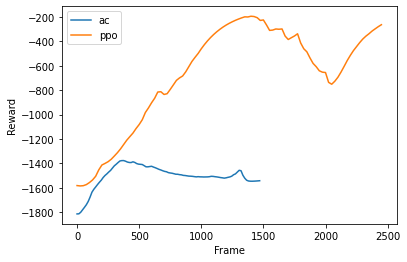

In [17]:
plt.ylabel("Reward")
plt.xlabel("Frame")
infos = [ac_pendulum_infos, ppo_pendulum_infos]
labels = ["ac", "ppo"]
for info in infos:
    x, y = info["episodes"],info["rewards"]
    y, x = moving_average(y, x)
    plt.plot(x, y)
plt.legend(labels)
plt.show()